In [1]:
import pandas as pd
import numpy as np

import _pickle as pickle
from collections import Counter
from pprint import pprint
from datetime import datetime
import shutil
import time
import os

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
ROOT_DIR = "../"

DATA_DIR = ROOT_DIR
RESULTS_DIR = ROOT_DIR + "results/"

# Train - 1460 (1168 + 292) videos 
# Test - 252 videos 

TRAINING_DATA = DATA_DIR + "video_training_data.p" # each read gives labelled video [(segment, label), segment_2, ...]
VALIDATION_DATA = DATA_DIR + "video_validation_data.p" 
TEST_DATA = DATA_DIR + "video_testing_data.p" # each read gives video [(segment), segment_2, ...]

## Load data from file

In [3]:
def get_next_video_data(f):    
    is_end_reached = False
    
    try:
        video = pickle.load(f) # [(segment, label), ...]
    except (EOFError):
        is_end_reached = True
        return [], is_end_reached
    
    return video, is_end_reached

## Model Architecture

**Temporal Model (RNN, LSTM, GRU):**
- [x] Add dropout
- [ ] Add stacking / another lstm
- [ ] No temporal pooling
- [x] Max pooling
- [x] Avg pooling
- [x] [Concat pooling](https://medium.com/@sonicboom8/sentiment-analysis-with-variable-length-sequences-in-pytorch-6241635ae130)
- [ ] CS4248 12-rnn slide 32: Use pooled hidden states (segment level) in another RNN, and predict for each resultatnt hidden state. 

**Try out models:**
- [ ] RNN
- [x] LSTM
- [x] GRU
- [ ] [QRNN](https://github.com/salesforce/pytorch-qrnn)
- [ ] Nested LSTM
- [ ] TCN


[LSTM vs GRU](https://blog.floydhub.com/gru-with-pytorch/) explanation and comparison article


**Training:**
- [ ] Shuffle data
- [ ] Xavier normal initialisation
- [ ] Xavier uniform initialisation


Yash- high validation accuracy for **hidden dim 50**. But test results are bad.


Don't use the SIL frames

In [42]:
class ClassPredictor(nn.Module):
    def __init__(self, input_size, num_classes, drop_prob):
        super(ClassPredictor, self).__init__()
        
        self.input_dout = nn.Dropout(drop_prob) 
        
        
        hidden_1 = 160
        hidden_2 = 100        
        
        # https://pytorch.org/docs/stable/nn.html#torch.nn.Linear
        self.fc1 = nn.Linear(input_size, hidden_1)
        self.bn1 = nn.BatchNorm1d(num_features=hidden_1)
        self.l_relu1 = nn.LeakyReLU()
        self.dout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.bn2 = nn.BatchNorm1d(num_features=hidden_2)
        self.l_relu2 = nn.LeakyReLU()
        
        self.out = nn.Linear(hidden_2, num_classes)
        
        with torch.no_grad():
            nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('leaky_relu'))
            nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('leaky_relu'))
            nn.init.xavier_uniform_(self.out.weight)
            
    def forward(self, x):
        ## x: (input_size)

        # Manually use dropout for the RNN output
        x = self.input_dout(x)
        
        a1 = self.fc1(x)
#         b1 = self.bn1(a1)
        h1 = self.l_relu1(a1)
        dout1 = self.dout1(h1)

        a2 = self.fc2(dout1)
#         b2 = self.bn2(a2)
        h2 = self.l_relu2(a2)
        
        # y: (num_classes)
        y = self.out(h2)

        return y

In [492]:
# Bidirectional recurrent neural network (many-to-one)
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        drop_prob = 0
        
        ## https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=True, 
                            batch_first=True, bias=True, dropout=drop_prob)
        
        ## DNN for class prediction
        self.fc = ClassPredictor(hidden_size * 2, num_classes)
 

    ## https://pytorch.org/docs/stable/nn.init.html
    def init_hidden_state(self, batch_size):
        #h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size)
        #c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size)

        h0 = torch.empty(self.num_layers * 2, batch_size, self.hidden_size).double()
        h0 = nn.init.orthogonal_(h0) # orthogonal_, xavier_normal_, xavier_uniform_
        
        c0 = torch.empty(self.num_layers * 2, batch_size, self.hidden_size).double()
        c0 = nn.init.orthogonal_(c0) # orthogonal_, xavier_normal_, xavier_uniform_

        h0 = h0.requires_grad_().cuda()
        c0 = c0.requires_grad_().cuda()
        
        return h0, c0
 

    def forward(self, x, segment_indices):
        ## x: (batch_size, seq_len, feature_len)
        ## segment_indices: (num_segments, 2)
        
        batch_size = x.size(0)

        ## Set initial states
        ## h0, c0: (num_layers * num_directions, batch_size, hidden_size)
        h0, c0 = self.init_hidden_state(batch_size)
        
        ## Forward propagate LSTM
        ## out: tensor of shape (batch_size, seq_length, hidden_size * 2)
        out, _ = self.bilstm(x, (h0, c0))  
        
        ## Use hidden states of each segment to predict their labels
        segment_outputs = []
        for (start, end) in segment_indices:
            hidden_states = out[:, start:end, :]
            
            ## Compute the hidden state by doing temporal pooling over all time steps
            ## pool_out: (hidden_size * 2)
            
            pool_out = torch.mean(hidden_states, dim=1).squeeze() # adaptive_avg_pool1d
#             pool_out = F.adaptive_max_pool1d(hidden_states.permute(0,2,1), 1).squeeze()

            ## concat_pool_out: (hidden_size * 2 * 2)
#             concat_pool_out = torch.cat([max_pool_out, avg_pool_out])

#             final_hidden_out = out[:, end - 1, :]
            
            ## output: (num_classes)
            output = self.fc(pool_out)
            
            segment_outputs.append(output)

        
        ## segment_outputs: (num_segments, num_classes)
        segment_outputs = torch.stack(segment_outputs)
        
        return segment_outputs

In [41]:
class BiGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiGRU, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        drop_prob = 0
        
        ## https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
        self.bigru =nn.GRU(input_size, hidden_size, num_layers, bidirectional=True, 
                            batch_first=True, bias=True) #, dropout=drop_prob) # dropout is only for stacked layers
        
        ## DNN for class prediction
        self.fc = ClassPredictor(hidden_size * 2 * 2, num_classes, drop_prob)
 

    ## https://pytorch.org/docs/stable/nn.init.html
    def init_hidden_state(self, batch_size):
        #h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size)

        h0 = torch.empty(self.num_layers * 2, batch_size, self.hidden_size).double()
        h0 = nn.init.orthogonal_(h0) # orthogonal_, xavier_normal_, xavier_uniform_
        h0 = h0.requires_grad_().cuda()
        
        return h0
 

    def forward(self, x, segment_indices):
        ## x: (batch_size, seq_len, feature_len)
        ## segment_indices: (num_segments, 2)
        
        batch_size = x.size(0)

        ## Set initial states
        ## h0: (num_layers * num_directions, batch_size, hidden_size)
        h0 = self.init_hidden_state(batch_size)
        
        ## Forward propagate
        ## out: tensor of shape (batch_size, seq_length, hidden_size * 2)
        out, _ = self.bigru(x, h0)  
        
        ## Use hidden states of each segment to predict their labels
        segment_outputs = []
        for (start, end) in segment_indices:
            hidden_states = out[:, start:end, :]
            
            ## Compute the hidden state by doing temporal pooling over all time steps
            ## pool_out: (hidden_size * 2)
            max_pool_out = F.adaptive_max_pool1d(hidden_states.permute(0,2,1), 1).squeeze()
            avg_pool_out = torch.mean(hidden_states, dim=1).squeeze() # adaptive_avg_pool1d

            ## concat_pool_out: (hidden_size * 2 * 2)
            concat_pool_out = torch.cat([max_pool_out, avg_pool_out])

#             final_hidden_out = out[:, end - 1, :]
            
            ## output: (num_classes)
            output = self.fc(concat_pool_out)
            
            segment_outputs.append(output)

        
        ## segment_outputs: (num_segments, num_classes)
        segment_outputs = torch.stack(segment_outputs)
        
        return segment_outputs

In [483]:
# hidden_states = v[:, 0:3, :]

# max_pool = F.adaptive_max_pool1d(hidden_states.permute(0,2,1), 1).squeeze()

# avg_pool = F.adaptive_avg_pool1d(hidden_states.permute(0,2,1), 1).squeeze()
# a_pool = torch.mean(hidden_states, dim=1).squeeze()

# a_pool
# avg_pool

## Train model on entire videos (sequence of segments which are sequence of frames)

In [6]:
def transform_to_inputs(video):
    segments = [] # segments (list of frames) in the video
    labels = [] # labels of each segment
    segment_indices = []
    offset = 0
    for segment_num in range(len(video)):
        segments.append(video[segment_num][0])
        labels.append(video[segment_num][1])
        segment_indices.append((offset, offset + video[segment_num][0].shape[0]))

        offset += video[segment_num][0].shape[0]
        
    # Load frames as tensors with gradient accumulation abilities
    input_frames = torch.cat(segments, 0).unsqueeze(0).requires_grad_().cuda() # unsqueeze to add batch dim
    labels = torch.Tensor(labels).long().cuda()
    segment_indices = torch.IntTensor(segment_indices).cuda()
    
    return input_frames, labels, segment_indices

In [40]:
def save_checkpoint(state, is_best, folder):
    filename = folder + 'model_checkpoint.pth'
    torch.save(state, filename)
    
    if is_best:
        shutil.copyfile(filename, folder + 'model_best.pth')

def train_model(model, num_epochs=10, train_data_file=TRAINING_DATA, validation_data_file=VALIDATION_DATA):
    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []
    best = float("inf")

    
    for epoch in range(num_epochs):
        start = time.time()
        print('======================================================================')
        print('Epoch: {}'.format(epoch))

        try:
            train_f.close()    
        except(NameError):
            pass   
        
        train_f = open(train_data_file, 'rb')
        should_epoch_end = False
        
        correct = 0
        total = 0

        video_num = 0
        epoch_training_losses = []

        model.train()
        while not should_epoch_end:
            video, should_epoch_end = get_next_video_data(train_f)
            if should_epoch_end:
                break
            
            inputs, labels, segment_indices = transform_to_inputs(video)

            outputs = model(inputs, segment_indices)
            loss = loss_criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_training_losses.append(loss.item())
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            video_num += 1
            if video_num % 150 == 0:
                print('      Video: {}/1168  Loss: {}'.format(video_num, np.mean(epoch_training_losses))) 

        train_f.close()            
        
        train_accuracy = 100 * correct / total
        
        
        # Evaluate on validation set
        try:
            val_f.close()    
        except(NameError):
            pass  
            
        val_f = open(validation_data_file, 'rb')
        model.eval()

        correct = 0
        total = 0
        is_file_end = False

        epoch_validation_losses = []
        while not is_file_end:
            video, is_file_end = get_next_video_data(val_f)
            if is_file_end:
                break
            
            inputs, labels, segment_indices = transform_to_inputs(video)
        
            outputs = model(inputs, segment_indices)
            loss = loss_criterion(outputs, labels)
            epoch_validation_losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        val_f.close()
        
        val_accuracy = 100 * correct / total
        
        
        # Print loss and accuracy
        training_losses.append(np.mean(epoch_training_losses))
        validation_losses.append(np.mean(epoch_validation_losses))
        training_accuracies.append(train_accuracy)
        validation_accuracies.append(val_accuracy)
        

        scheduler.step(validation_losses[-1])

        end = time.time()

        print('   Training Loss: {:.5f}  Validation Loss: {:.5f}'.format(training_losses[-1], validation_losses[-1]))
        print('   Training Accuracy: {:.3f}%   Validation Accuracy: {:.3f}%'.format(train_accuracy, val_accuracy))        
        
        is_best = validation_losses[-1] < best
        best = min(validation_losses[-1], best)
        save_checkpoint({
            'next_epoch_idx': epoch + 1,
            'state_dict': model.state_dict(),
            'val_loss': validation_losses[-1],
            'optimizer' : optimizer.state_dict(),
        }, is_best, RESULTS_DIR + model_time + '/')

        print('Best Validation Loss: {:.5f}'.format(best))
        print('Epoch took {:.2f} minutes'.format((end - start) / 60))

    return training_losses, validation_losses, training_accuracies, validation_accuracies

In [43]:
model_time = str(datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
os.mkdir(RESULTS_DIR + model_time)

## Model Architecture
input_dim = 400  # dimension of an i3D video frame
hidden_dim = 90 # dimension of hidden state
layer_dim = 1    # number of stacked layers
output_dim = 48  # number of sub-action labels


# model = BiLSTM(input_dim, hidden_dim, layer_dim, output_dim)
model = BiGRU(input_dim, hidden_dim, layer_dim, output_dim)

model = model.double().cuda() # transform the model parameters to double precision


## Loss function
loss_criterion = nn.CrossEntropyLoss()


## Optimizer
learning_rate = 0.01
weight_decay = 0.0002
momentum = 0.9

# optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) 
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=weight_decay) 


## Learning Rate Scheduler
patience = 2
decrease_factor = 0.7
min_learning_rate = 0.00005
scheduler = ReduceLROnPlateau(optimizer, mode='min', 
                              patience=patience, min_lr=min_learning_rate, factor=decrease_factor,
                              verbose=True)


num_epochs = 25

training_losses, validation_losses, training_accuracies, validation_accuracies = train_model(model,num_epochs=num_epochs) # TODO: batch_sizes

path = RESULTS_DIR + model_time + "/bidirectional_video_model.pth"
torch.save(model.state_dict(), path)
print("\nSaved trained model to", path)

Epoch: 0
      Video: 150/1168  Loss: 3.814192301355535
      Video: 300/1168  Loss: 3.667864787147778
      Video: 450/1168  Loss: 3.5484529048198925
      Video: 600/1168  Loss: 3.4637186631694323
      Video: 750/1168  Loss: 3.386557983029371
      Video: 900/1168  Loss: 3.2889380743361465
      Video: 1050/1168  Loss: 3.213468452692358
   Training Loss: 3.16269  Validation Loss: 2.47652
   Training Accuracy: 14.849%   Validation Accuracy: 27.080%
Best Validation Loss: 2.47652
Epoch took 6.59 minutes
Epoch: 1
      Video: 150/1168  Loss: 2.435396939777677
      Video: 300/1168  Loss: 2.475640879680512
      Video: 450/1168  Loss: 2.4497851302694067
      Video: 600/1168  Loss: 2.430538641057824
      Video: 750/1168  Loss: 2.3984359972773617
      Video: 900/1168  Loss: 2.362213711880791
      Video: 1050/1168  Loss: 2.3339386272211273
   Training Loss: 2.31634  Validation Loss: 1.93523
   Training Accuracy: 30.281%   Validation Accuracy: 39.492%
Best Validation Loss: 1.93523
Epoch 

      Video: 150/1168  Loss: 0.7205987520141143
      Video: 300/1168  Loss: 0.720004110219316
      Video: 450/1168  Loss: 0.7258781033610069
      Video: 600/1168  Loss: 0.7382498160529447
      Video: 750/1168  Loss: 0.737955147217699
      Video: 900/1168  Loss: 0.7411712153246144
      Video: 1050/1168  Loss: 0.7450974848014482
   Training Loss: 0.75516  Validation Loss: 1.00464
   Training Accuracy: 69.153%   Validation Accuracy: 62.976%
Best Validation Loss: 1.00464
Epoch took 6.72 minutes
Epoch: 15
      Video: 150/1168  Loss: 0.6719907837124223
      Video: 300/1168  Loss: 0.6735713386591423
      Video: 450/1168  Loss: 0.6836400699036491
      Video: 600/1168  Loss: 0.7042457135139414
      Video: 750/1168  Loss: 0.7070041640400561
      Video: 900/1168  Loss: 0.7074426690841222
      Video: 1050/1168  Loss: 0.7116411902568109
   Training Loss: 0.71978  Validation Loss: 1.00633
   Training Accuracy: 70.285%   Validation Accuracy: 62.835%
Best Validation Loss: 1.00464
Epoch to

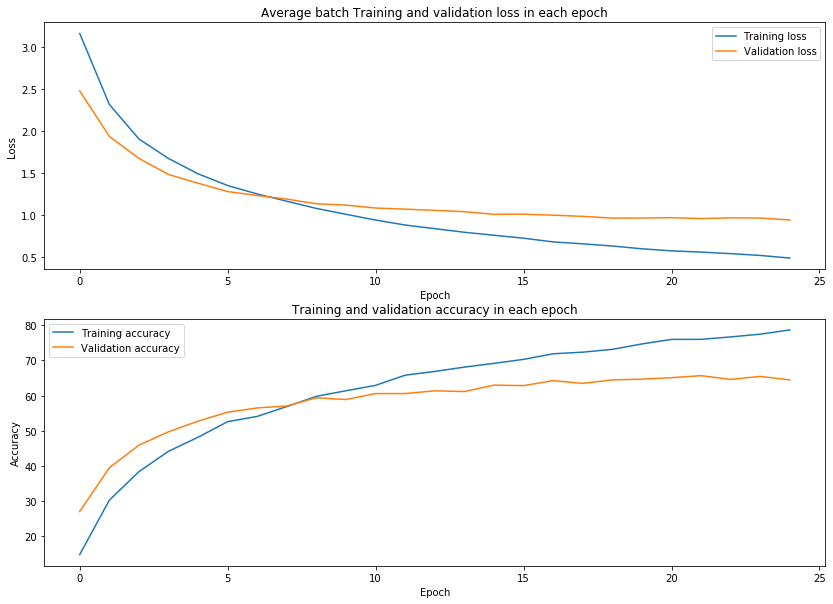

In [54]:
plt.figure(figsize=(14,10))

# Plot training and validation losses
plt.subplot(2, 1, 1)
plt.title("Average batch Training and validation loss in each epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(training_losses)
plt.plot(validation_losses)
plt.legend(["Training loss","Validation loss"])

# Plot training and validation accuracies
plt.subplot(2, 1, 2)
plt.title("Training and validation accuracy in each epoch")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(training_accuracies)
plt.plot(validation_accuracies)
plt.legend(["Training accuracy","Validation accuracy"])

In [33]:
# # Load saved checkpoint
# # checkpoint_path = RESULTS_DIR + "2020-04-05_20-52-22" + "/model_checkpoint.pth"
# checkpoint_path = RESULTS_DIR + "2020-04-05_23-58-40" + "/model_best.pth"

# checkpoint = torch.load(checkpoint_path)

# next_epoch_idx = checkpoint['next_epoch_idx']
# val_loss = checkpoint['val_loss']
# model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])

# print("=> loaded checkpoint '{}' (next_epoch_idx {})".format(checkpoint_path, next_epoch_idx))

# # # Load saved model
# # path = RESULTS_DIR + "2020-03-21-_04-30-14" + "/bilstm_video_model.pth"
# # model.load_state_dict(torch.load(path))

=> loaded checkpoint '../results/2020-04-05_20-52-22/model_best.pth' (next_epoch_idx 22)


# Evaluate model on validation set

In [46]:
model.eval()

try:
    val_f.close()    
except(NameError):
    ;   
val_f = open(VALIDATION_DATA, 'rb')

y = {'Actual': [], 'Predicted': []}

is_file_end = False
while not is_file_end:
    video, is_file_end = get_next_video_data(val_f)
    if is_file_end:
        break

    inputs, labels, segment_indices = transform_to_inputs(video)

    outputs = model(inputs, segment_indices)

    _, predicted = torch.max(outputs.data, 1)
    
    y['Actual'].extend(labels.tolist())
    y['Predicted'].extend(predicted.tolist())
    
y_df = pd.DataFrame(y)
path = RESULTS_DIR + model_time + "/val_results.csv"        
y_df.to_csv(path, encoding='utf-8', index=False)

print('Done predicting on validation set. Saved to', path)

Done predicting on validation set. Saved to ../results/2020-04-05_23-58-40/val_results.csv


In [47]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score

print('\nMacro f1 Score= %.4f' % f1_score(y['Actual'], y['Predicted'], average="macro"))
print('Macro Precision= %.4f' % precision_score(y['Actual'], y['Predicted'], zero_division=0, average="macro"))
print('Macro Recall= %.4f' % recall_score(y['Actual'], y['Predicted'], average="macro")) 

print('\nMicro f1 Score= %.4f' % f1_score(y['Actual'], y['Predicted'], average="micro"))
print('Micro Precision= %.4f' % precision_score(y['Actual'], y['Predicted'], zero_division=0, average="micro"))
print('Micro Recall= %.4f' % recall_score(y['Actual'], y['Predicted'], average="micro")) 

print('\nAccuracy: %.4f' % accuracy_score(y['Actual'], y['Predicted']))

# Computes the average AUC of all possible pairwise combinations of classes. 
# Insensitive to class imbalance when average == 'macro'.
# print(roc_auc_score(y['Actual'], y['Predicted'], multi_class='ovo', average='macro')) 


Macro f1 Score= 0.5121
Macro Precision= 0.5295
Macro Recall= 0.5181

Micro f1 Score= 0.6509
Micro Precision= 0.6509
Micro Recall= 0.6509

Accuracy: 0.6509


# Generate test data predictions for submission

In [48]:
NUM_TEST_SEGMENTS = 1284

model.eval()

try:
    test_f.close()    
except(NameError):
    pass   
test_f = open(TEST_DATA, 'rb')

y_pred = {'Id': np.arange(NUM_TEST_SEGMENTS), 'Category': []}

def transform_to_test_inputs(video):
    segments = [] # segments (list of frames) in the video
    segment_indices = []
    offset = 0
    for segment_num in range(len(video)):
        segments.append(video[segment_num])
        segment_indices.append((offset, offset + video[segment_num].shape[0]))

        offset += video[segment_num].shape[0]

    # Load frames as tensors with gradient accumulation abilities
    input_frames = torch.cat(segments, 0).unsqueeze(0).requires_grad_().cuda() # unsqueeze to add batch dim
    segment_indices = torch.IntTensor(segment_indices).cuda()
    
    return input_frames, segment_indices
        
is_end_reached = False
while not is_end_reached:
    video, is_end_reached = get_next_video_data(test_f)

    if is_end_reached:
        break

    inputs, segment_indices = transform_to_test_inputs(video)
    
    outputs = model(inputs, segment_indices)
    _, predicted = torch.max(outputs.data, 1)
    
    y_pred['Category'].extend(predicted.tolist())

y_pred_df = pd.DataFrame(y_pred)
path = RESULTS_DIR + model_time + "/" + model_time + "_predictions_submission.csv"
y_pred_df.to_csv(path, encoding='utf-8', index=False)

print('Done predicting on test data. Saved to', path)

Done predicting on test data. Saved to ../results/2020-04-05_23-58-40/2020-04-05_23-58-40_predictions_submission.csv
